In [46]:
import pandas as pd
import numpy as np
import imageio
from skimage import io
import matplotlib.pyplot as plt
from scipy.stats import kruskal, normaltest
import dask
import dask.dataframe as dd
import dask.array as da
%matplotlib inline
import re
import os
import glob

# Read data

In [2]:
df = pd.read_csv('train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [4]:
df.describe()

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
max,90.000000,1.000000


# Metadata univariate EDA

In [5]:
df.shape

(33126, 8)

In [6]:
len(df['patient_id'].unique())

2056

In [7]:
df['patient_id'].value_counts()

IP_4382720    115
IP_4479736    115
IP_7279968    115
IP_4938382    115
IP_0656529    114
             ... 
IP_0408084      3
IP_5621584      3
IP_0491775      3
IP_8576640      3
IP_8335299      2
Name: patient_id, Length: 2056, dtype: int64

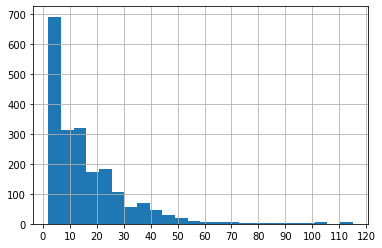

In [8]:
_ = df['patient_id'].value_counts().hist(bins=24)
_ = plt.xticks(range(0,130,10))

In [9]:
df['sex'].value_counts()

male      17080
female    15981
Name: sex, dtype: int64

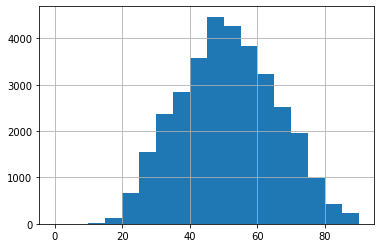

In [10]:
_ = df['age_approx'].hist(bins=18)

In [11]:
df['anatom_site_general_challenge'].value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

In [12]:
df['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

In [13]:
df['benign_malignant'].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

In [14]:
df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

## Conclusions
There are 33,000 images, from 2056 patients. There are a few patients with over 60 images. The vast majority of patients have fewer than 10 images.

The data is relatively evenly split between male and female. It is normally distributed with regard to age, weith a slight left skew. Additionally, most images come from the torso or lower extremity.

In comparison of `diagnosis` and `benign_malignant`, the numbers for `melanoma` and `malignant` are the same. It is likely that `malignant` means `melanoma` here. Similarly, `target` contains the same number of `1` values as `benign_malignant` does `malignant`. We will confirm these correlations during multivariate EDA.

# Metadata multivariate EDA

In [15]:
files = os.listdir('train')

In [16]:
len(files)

33791

In [17]:
test = imageio.imread(f'train/{files[0]}')

DICOM file contained compressed data. Autoconverting with dcmdjpeg (this warning is shown once for each directory)


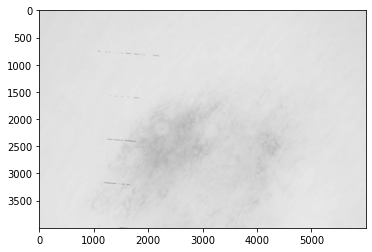

In [18]:
_ = plt.imshow(test, cmap='gray')

In [19]:
type(test)

imageio.core.util.Array

Examination of the `train` directory shows that certain files contain a `.raw` extension. Those files don't exist in the csv, and they are not sized correctly. There are also proper duplicates of each:

We will therefore remove all raw files.

In [20]:
# if {re.search('[raw]', i) for i in os.listdir('train/')} != {None}:
#     print('Purging raw files.')
#     for path in glob.glob('train/*.raw'):
#         os.remove(path)
# else:
#     print('All raw files purged.')

In [21]:
clean_files = os.listdir('train')
len(clean_files) == len(df['image_name'])

False

## Add images to dataframe

In [22]:
df['image_path'] = df['image_name'].apply(lambda x: f'jpeg/train/{x}.jpg')

In [23]:
ddf = dd.from_pandas(df, npartitions=100)

delayed_imread = dask.delayed(imageio.imread)
ddf['image'] = ddf['image_path'].apply(delayed_imread, meta=('image',np.uint8))

## Extract sample

In [24]:
sample = ddf.partitions[1]
sample = sample.compute()

In [26]:
sample.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,image_path,image
332,ISIC_0214186,IP_0232771,male,75.0,torso,unknown,benign,0,jpeg/train/ISIC_0214186.jpg,"[[[182, 139, 123], [182, 139, 123], [183, 140,..."
333,ISIC_0214335,IP_0825081,male,80.0,head/neck,unknown,benign,0,jpeg/train/ISIC_0214335.jpg,"[[[22, 14, 12], [23, 15, 13], [24, 16, 14], [2..."
334,ISIC_0214635,IP_6601134,female,55.0,upper extremity,unknown,benign,0,jpeg/train/ISIC_0214635.jpg,"[[[167, 115, 119], [168, 116, 120], [168, 116,..."
335,ISIC_0214903,IP_3789216,male,50.0,torso,nevus,benign,0,jpeg/train/ISIC_0214903.jpg,"[[[187, 115, 127], [189, 117, 129], [191, 119,..."
336,ISIC_0215054,IP_8091497,male,45.0,head/neck,unknown,benign,0,jpeg/train/ISIC_0215054.jpg,"[[[18, 18, 16], [18, 18, 16], [18, 18, 16], [1..."


In [27]:
MB = 1024
sample.memory_usage().sum()/MB

26.06640625

In [28]:
sample.shape

(332, 10)

In [30]:
len(sample['patient_id'].unique())

290

### Image EDA

I would like to see if benign and malignant images share a common spread of image intensities. To do so, I will perform a Kruskal H-test (see below for confirmation of nonparametric data, thus necessitating a nonparametric alternative to ANOVA). The Kruskal test will examine both standard deviation and mean of the images. A significant test statistic would suggest a straightforward method of classification for melanomas.

In [ ]:
normaltest(sample.loc[benign, 'image_std'])

In [33]:
benign = sample['benign_malignant'] == 'benign'
malignant = sample['benign_malignant'] == 'malignant'
sample['benign_malignant'].value_counts()

benign       323
malignant      9
Name: benign_malignant, dtype: int64

In [48]:
sample['image_std'] = sample['image'].apply(lambda x: x.std())
sample['image_mean'] = sample['image'].apply(lambda x: x.mean())

In [49]:
kruskal(sample.loc[benign, 'image_std'], sample.loc[malignant, 'image_std'])

KruskalResult(statistic=0.0047136920201182875, pvalue=0.9452631775968527)

In [50]:
kruskal(sample.loc[benign, 'image_mean'], sample.loc[malignant, 'image_std'])

KruskalResult(statistic=26.189189189189165, pvalue=3.0955067058454613e-07)

The results of these values present a more complicated picture than a simple analysis of variances might provide. Pattern matching will likely be necessary in the form of a deep neural net.